<a href="https://colab.research.google.com/github/omarcordero1/ArregloBidimensional/blob/Practica_c/SEO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Análisis de posicionamiento orgánico Milenio 6 meses*

In [ ]:
###Cargar liberias

% matplotlib inline
import pandas as pd

In [ ]:
compras_df= pd.read_csv('/content/Queries.csv')
data.head

<bound method NDFrame.head of      Top queries  CTR
0            610  390
1            604  761
2            121  722
3            874  148
4            115  556
..           ...  ...
995          588  349
996          470  356
997          783  365
998          961  798
999          479  327

[1000 rows x 2 columns]>

# Módelo supervisado

In [ ]:
data.describe()

,Clicks,Impressions,Position
count,1.000000e+03,1.000000e+03,1000.000000
mean,2.933468e+04,1.186177e+06,4.192110
std,5.823951e+04,5.685173e+06,1.998171
min,9.480000e+03,1.493700e+04,1.000000
25%,1.179600e+04,1.103818e+05,2.667500
50%,1.603450e+04,2.865110e+05,3.885000
75%,2.899875e+04,7.454222e+05,5.452500
max,1.403643e+06,1.002235e+08,13.150000


In [ ]:
data = compras_df.copy()
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [ ]:
data.head()

,Top queries,Clicks,Impressions,CTR,Position
0,610,1403643,5351785,390,1.56
1,604,758939,8793965,761,3.62
2,121,294087,3876510,722,3.37
3,874,275241,2348242,148,2.92
4,115,254466,5257899,556,3.81


In [ ]:
###Regresor de sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

In [ ]:
##Posición
y = data.pop('Position')
X = data.copy()

In [ ]:
##Test de entrenamiento

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [ ]:
##Correr random forest

clf = RandomForestRegressor(n_estimators=1000, max_depth = 4)

In [ ]:
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(y_test, clf.predict(X_test))


0.27658193562349687

#Probar un modelo no supervisado o de clustering para texto


In [ ]:
import gensim
from nltk.corpus import stopwords
import numpy as np
np.random.seed(2021)

In [ ]:
def preprocess(text):
    result = []
    for token in text.split():
        if token not in stopwords.words('spanish') and len(token)>4:
            result.append(token)
    return result

In [ ]:
import nltk
nltk.download('stopwords')
process_business = [preprocess(x) for x in list(compras_df['Top queries'].unique())]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dictionary = gensim.corpora.Dictionary(process_business)


In [ ]:
dictionary.filter_extremes(no_below=1, no_above=0.5)


In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in process_business]


In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=10, workers=2)


In [ ]:
for idx, type_business in lda_model.print_topics(-1):
    print('Topic:{} Words:{}'.format(idx, type_business))

Topic:0 Words:0.108*"noticias" + 0.034*"vacuna" + 0.024*"jornada" + 0.024*"monterrey" + 0.022*"guardianes" + 0.019*"méxico" + 0.015*"ultimas" + 0.015*"última" + 0.015*"cansino" + 0.012*"santa"
Topic:1 Words:0.031*"significado" + 0.019*"veracruz" + 0.019*"mexico" + 0.019*"11:11" + 0.016*"ocaña" + 0.016*"coronavirus" + 0.013*"octavio" + 0.013*"eclipse" + 0.010*"diputados" + 0.010*"incendio"
Topic:2 Words:0.074*"covid" + 0.056*"mexico" + 0.043*"noticias" + 0.032*"puebla" + 0.023*"vacuna" + 0.022*"semaforo" + 0.016*"universo" + 0.016*"aguilar" + 0.014*"cambio" + 0.014*"angela"
Topic:3 Words:0.031*"canelo" + 0.026*"miguel" + 0.024*"elecciones" + 0.019*"pelea" + 0.019*"final" + 0.019*"resultados" + 0.016*"jalisco" + 0.016*"mexico" + 0.013*"negro" + 0.013*"hongo"
Topic:4 Words:0.025*"huracan" + 0.022*"sinovac" + 0.019*"grace" + 0.017*"circula" + 0.017*"metro" + 0.015*"vacuna" + 0.014*"sergio" + 0.011*"horario" + 0.011*"cupones" + 0.011*"trayectoria"
Topic:5 Words:0.076*"elecciones" + 0.033*"n

In [ ]:
def get_max_topic(index):
    results = lda_model[bow_corpus[index]]
    return max(lda_model[results], key=lambda x: x[1])[0]

In [ ]:
business_cluster = {x: get_max_topic(i) for i, x in enumerate(list(compras_df['Top queries'].unique()))}


In [ ]:
compras_df['CLUSTER_NAME'] = compras_df['Top queries'].apply(lambda x: business_cluster[x])


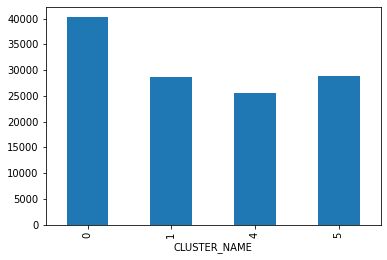

In [ ]:
compras_df.groupby('CLUSTER_NAME')['Clicks'].mean().plot.bar()


#Modelo Supervisado en relación a Clics

In [ ]:
import numpy as np
from scipy.stats import norm

In [ ]:
params = norm.fit(compras_df['Clicks'])


In [ ]:
params

(29334.684, 58210.38177286028)

In [ ]:
compras_df['PROB_TOTAL'] = [norm(params[0], params[1]).cdf(x) for x in compras_df['Clicks']]


In [ ]:
compras_df[compras_df['PROB_TOTAL']>0.95]

,Top queries,Clicks,Impressions,CTR,Position,CLUSTER_NAME,PROB_TOTAL
0,noticias de hoy,1403643,5351785,26.23%,1.56,0,1.000000
1,noticias,758939,8793965,8.63%,3.62,0,1.000000
2,cepillin,294087,3876510,7.59%,3.37,1,0.999997
3,sergio basteri,275241,2348242,11.72%,2.92,1,0.999988
4,carmen salinas,254466,5257899,4.84%,3.81,5,0.999945
5,la aficion,243153,283856,85.66%,1.01,1,0.999880
6,resultados elecciones 2021,227998,1115093,20.45%,1.81,4,0.999679
7,octavio ocaña,221244,5676384,3.9%,5.32,5,0.999511
8,zac efron,213356,2915987,7.32%,4.64,0,0.999215
9,michelle salas,192627,3782355,5.09%,4.47,1,0.997486


In [ ]:
models_sheet={}
for sheet in list(compras_df['Top queries'].unique()):
    sheet_compras = compras_df[compras_df['Top queries'] == sheet]
    params = norm.fit(sheet_compras['Clicks'])
    models_sheet[sheet] = norm(params[0], params[1])

In [ ]:
sheet_prob = []
for i, row in compras_df.iterrows():
    sheet_prob.append(models_sheet[row['Top queries']].cdf(row['Clicks']))
compras_df['PROB_SHEET'] = sheet_prob

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1824: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [ ]:
compras_df[compras_df['PROB_SHEET']>0.95]


,Top queries,Clicks,Impressions,CTR,Position,CLUSTER_NAME,PROB_TOTAL,PROB_SHEET


#Conclusiones

Se observa una consistencia de palabras como noticias, fecha y noticias de hoy, por un lado, por otro es importante trabajar en el posicionamiento de marca de la afición, puesto que se toma como un dato atípico, es decir no tiene un comportamiento constante como el resto de palabras de marca, como Milenio o M2

Horario de Verano, Cambio de horario son keywords recurrentes, es importante que en estas coyunturas intentemos no perdes el posicionamiento y sabes que generan un fuerte interés de los usuarios, muchas impresiones, pero pocos clic, por ende es muy importante, que revisemos la Metadata en concreto de estos contenidos y trabajemos en notas de segundo nivel, mismo comportamiento que elecciones y Miss Universo

Por otro lado es fundamental
1) Trabajar los Minuto a Minuto en partidos, puesto que es una gran oportunidad para atraer tráfico
2) Trabajar una estrategía conjunta con con Telediario para empezar a ganar keywords

Noticias + Región o Ciudad


